<a href="https://colab.research.google.com/github/lkat6/ML-Project-01/blob/main/Detecting_Pneumonia_using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Chest X-ray Images Project Introduction 
## for pneumonia detection with CNN deep learning

kaggle link:
https://www.kaggle.com/tolgadincer/labeled-chest-xray-images
Context
Pneumonia is an infection that inflames the air sacs in one or both lungs. It kills more children younger than 5 years old each year than any other infectious disease, such as HIV infection, malaria, or tuberculosis. Diagnosis is often based on symptoms and physical examination. Chest X-rays may help confirm the diagnosis.

Content
This dataset contains 5856 validated Chest X-Ray images. The images are split into a training set and a testing set of independent patients. Images are labeled as (disease:NORMAL/BACTERIA/VIRUS)-(randomized patient ID)-(image number of a patient). For details of the data collection and description, see the referenced paper below.

According to the paper, the images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou.


#Why do I select this project 
In this project, CNN algorithm is used to identify the symptoms of pneumonia from chest X-ray images of the patients. This technique would substantially help improve our current health care system during both emergency and regular periods.

In regular times,the time cost of healthcare service is especially important in developing countries where a doctor needs to consult 20-30 patients a day in average. The X-Ray image identification shall facilitate the doctors in disease dignostic processes, leading to a faster medical service.

In emergency times, like during the early stage of the Convid-19 pandemic, as no quick scanning test (PCR) was invented, doctors relied on chest X-ray imaging to distinguish Convid-19. Since hospitals are full of patients await for treatments and doctors and nurses are working under overwhelmed pressure, CNN technique shall effectively take the burden from the doctors and thus saving more time for those who need immediate cares.

In this study,instead of the Convid-19, the CNN is applied to the detection of pneumonia from children under 5 years old. However, the CNN deep learning mentality can be used in many other chest symptom identification processes


In [1]:
## I am using Colab GPU to perform the computation
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## Check GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
## Compare GPU with CPU
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.0166590729999996
GPU (s):
0.040096865999998954
GPU speedup over CPU: 75x


In [4]:
import os
from tensorflow import keras
import seaborn as sns 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from matplotlib import image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, f1_score, precision_score, recall_score
from sklearn.utils import class_weight

In [5]:
#Create a function to calculate the files in a directory
def calculate_files(link):
    return (len([name for name in os.listdir(link)]))

In [7]:
train_normal = calculate_files('/content/drive/My Drive/Pneumonia/chest_xray/train/NORMAL')
train_pneumonia = calculate_files('/content/drive/My Drive/Pneumonia/chest_xray/train/PNEUMONIA')
test_normal = calculate_files('/content/drive/My Drive/Pneumonia/chest_xray/test/NORMAL')
test_pneumonia = calculate_files('/content/drive/My Drive/Pneumonia/chest_xray/test/PNEUMONIA')

In [8]:
#Create a dataframe with count of each class in the train dataset
train_barplot = pd.DataFrame({'number_of_images':[train_normal,train_pneumonia], 'disease':['normal', 'pneumonia']})
display(train_barplot)

,number_of_images,disease
0,1349,normal
1,3883,pneumonia


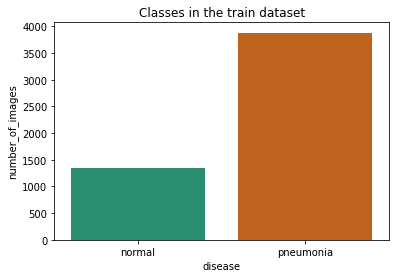

In [11]:
#Plot classes of the train dataset
sns.barplot(y = 'number_of_images', x = 'disease', 
            data = train_barplot,
            palette=("Dark2")).set_title('Classes in the train dataset');

In [13]:
#Create a dataframe with count of each class in the test dataset 
test_barplot = pd.DataFrame({'number_of_images':[test_normal,test_pneumonia], 'disease':['normal', 'pneumonia']})
display(test_barplot)

,number_of_images,disease
0,234,normal
1,390,pneumonia


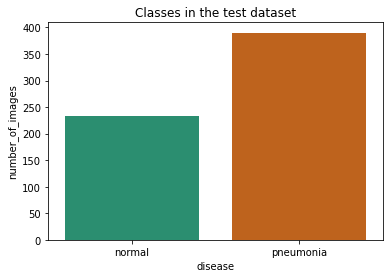

In [14]:
#Plot classes of the test dataset
sns.barplot(y = 'number_of_images', x = 'disease', 
            data = test_barplot,
            palette=("Dark2")).set_title('Classes in the test dataset');

Display A Random Images From Sick Cases


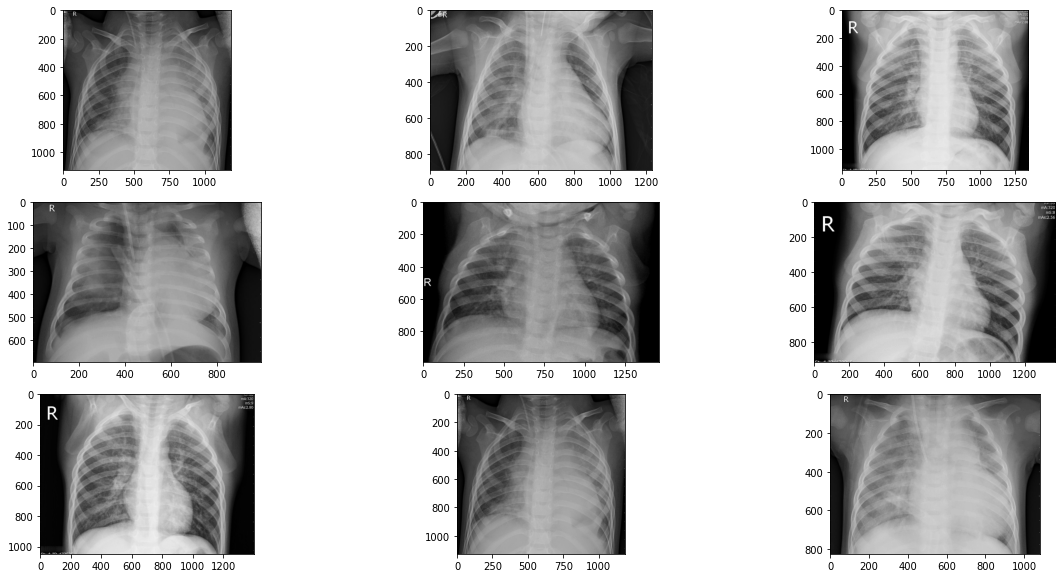

In [18]:
# Extract numpy values from Normal test/sick directory
images = [name for name in os.listdir('/content/drive/My Drive/Pneumonia/chest_xray/test/PNEUMONIA')]

#set a pseudorandom generator to consistency
np.random.seed(42)
random_images = [np.random.choice(images, replace = False) for i in range(9)]

# Location of the image dir
img_dir = '/content/drive/My Drive/Pneumonia/chest_xray/test/PNEUMONIA'

print('Display A Random Images From Sick Cases')

# Adjust the size of the images
plt.figure(figsize=(20,10))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3,3,i+1)
    img = plt.imread(os.path.join(img_dir,random_images[i]))
    plt.imshow(img,cmap='gray') 

Display Random Images From Healthy Cases


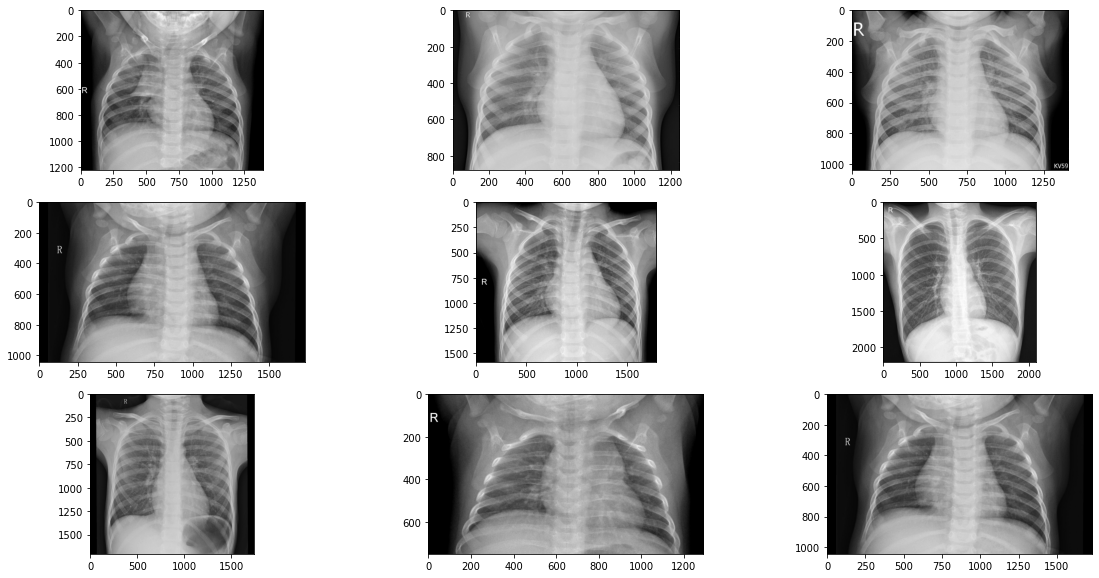

In [17]:
# Extract numpy values from Normal test/normal directory
images = [name for name in os.listdir('/content/drive/My Drive/Pneumonia/chest_xray/test/NORMAL')]

#set a pseudorandom generator to consistency
np.random.seed(42)
random_images = [np.random.choice(images, replace = False) for i in range(9)]

# Location of the image dir
img_dir = '/content/drive/My Drive/Pneumonia/chest_xray/test/NORMAL'

print('Display Random Images From Healthy Cases')

# Adjust the size of the images
plt.figure(figsize=(20,10))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3,3,i+1)
    img = plt.imread(os.path.join(img_dir,random_images[i]))
    plt.imshow(img,cmap='gray') 

In [21]:
#Create image generators
train_datagen = ImageDataGenerator(
    samplewise_center=True, #Set each sample mean to 0.
    samplewise_std_normalization= True, # Divide each input by its standard deviation
    rotation_range=10,#Degree range for random rotations.
    width_shift_range=0.1,#fraction of total width rotation
    height_shift_range=0.1,#fraction of total height rotation
    rescale=1./255,#Scale the pixels to [0,1]
    validation_split = 0.2) #Fraction of images reserved for validation

test_datagen = ImageDataGenerator(
    samplewise_center=True, 
    samplewise_std_normalization= True, 
    rescale=1./255)

In [22]:
#Load images
train_generator = train_datagen.flow_from_directory(
    directory=r"/content/drive/My Drive/Pneumonia/chest_xray/train/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=64,
    class_mode="binary",
    shuffle=True,
    subset = "training",
    seed=42
)

valid_generator = train_datagen.flow_from_directory(
    directory=r"/content/drive/My Drive/Pneumonia/chest_xray/train/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=64,
    class_mode="binary",
    shuffle=True,
    subset = "validation",
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    directory=r"/content/drive/My Drive/Pneumonia/chest_xray/test/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=64,
    class_mode=None,
    shuffle=False,
    seed = 42
)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


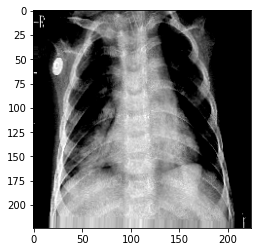

In [ ]:
#Visualize a first image after preprocessing
x_train, y_train = valid_generator.__getitem__(0)
plt.imshow(x_train[0]);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


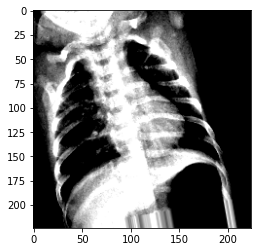

In [ ]:
x_val, y_val = train_generator.__getitem__(0)
plt.imshow(x_val[0]);

In [19]:
initial_bias = np.log([train_pneumonia/train_normal])
initial_bias

array([1.05724447])

In [ ]:
## Transfer Learning Approach using pre-trained DenseNet121 Model

from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

# create the base pre-trained model
base_model = DenseNet121(weights='imagenet', input_shape= (224, 224, 3), include_top=False)

#freeze the base model.
base_model.trainable = False

inputs = keras.Input(shape= (224, 224, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1, activation = 'sigmoid', 
                             bias_initializer=keras.initializers.Constant(initial_bias)
)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(), metrics=keras.metrics.Recall())

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

model.fit(train_generator, 
          validation_data=valid_generator,
          steps_per_epoch=100,      
          validation_steps=400, 
          callbacks = early_stopping_cb,
          epochs = 1000)

Epoch 1/1000
100/100 [==============================] - 726s 7s/step - loss: 0.3528 - recall: 0.9656 - val_loss: 0.2391 - val_recall: 0.9575


In [ ]:
#define a default treshold 0.5
def treshold(pred):
    if pred <= 0.5:
        return 0
    else:
        return 1

In [ ]:
def assess_model(model):
    predicted_vals = model.predict(test_generator, steps = len(test_generator))
    vfunc = np.vectorize(treshold)
    predictions = vfunc(predicted_vals)
    accuracy = accuracy_score(test_generator.classes, predictions)
    print('Accuracy: %f' % accuracy)
    print()
    f1 = f1_score(test_generator.classes, predictions)
    print('F1 score: %f' % f1)
    print()
    precision = precision_score(test_generator.classes, predictions)
    print('Precision_score : %f' % precision)
    print()
    recall = recall_score(test_generator.classes, predictions)
    print('Recall_score: %f' % recall)
    print()
    print('Confusion matrix')
    cm = confusion_matrix(y_true=test_generator.classes, y_pred=predictions)
    print(cm)

In [ ]:
assess_model(model)

Accuracy: 0.841346

F1 score: 0.882002

Precision_score : 0.824053

Recall_score: 0.948718

Confusion matrix
[[155  79]
 [ 20 370]]
